# Data Cleaning with Pandas

This notebook demonstrates a complete data cleaning workflow in Pandas using two example datasets:

1. **Retail customer feedback** (customer satisfaction scenario).
2. **Student performance** (education domain).


In [1]:
import pandas as pd
import numpy as np


## 1. Load Raw Datasets

In [2]:
retail_raw = pd.read_csv('retail_feedback_raw.csv')
students_raw = pd.read_csv('student_performance_raw.csv')
retail_raw.head()

,customer_id,store_city,feedback_source,rating,purchase_amount,age,visit_date,feedback_text
0,1083,NYC,email,3.0,$40,44.0,03-16-23,NaN
1,1053,New York,online,2.0,$120.00,44.0,2023-04-23,very long wait time
2,1070,Chicago,online,4.0,NaN,52.0,2023-04-14,NaN
3,1045,NYC,NaN,NaN,$40,NaN,2023-12-06,Store was clean
4,1044,NYC,Online,6.0,60.5,52.0,09-11-23,very long wait time


## 2. Inspect Retail Feedback Data and Identify Issues

In [3]:
# Shape and basic info
print('Retail raw shape:', retail_raw.shape)
print('\nInfo:')
print(retail_raw.info())

print('\nMissing values per column:')
print(retail_raw.isna().sum())

print('\nValue counts for key columns:')
print('\nstore_city:')
print(retail_raw['store_city'].value_counts(dropna=False))
print('\nfeedback_source:')
print(retail_raw['feedback_source'].value_counts(dropna=False))
print('\nrating:')
print(retail_raw['rating'].value_counts(dropna=False))
print('\npurchase_amount:')
print(retail_raw['purchase_amount'].value_counts(dropna=False).head())

print('\nNumber of duplicate rows:', retail_raw.duplicated().sum())

Retail raw shape: (45, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      45 non-null     int64  
 1   store_city       45 non-null     object 
 2   feedback_source  32 non-null     object 
 3   rating           39 non-null     float64
 4   purchase_amount  35 non-null     object 
 5   age              33 non-null     float64
 6   visit_date       45 non-null     object 
 7   feedback_text    38 non-null     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.9+ KB
None

Missing values per column:
customer_id         0
store_city          0
feedback_source    13
rating              6
purchase_amount    10
age                12
visit_date          0
feedback_text       7
dtype: int64

Value counts for key columns:

store_city:
store_city
San Fran         11
NYC               9
New York          6
LA    

### Issues observed in retail_feedback_raw.csv

- Duplicate rows.
- Inconsistent city names (e.g. `New York`, `new york`, `NYC`, `LA`, `San Fran`, `chi town`).
- Inconsistent feedback source labels (e.g. `in-store`, `In store`, `online`, `Online`).
- Ratings outside the valid 1–5 range (e.g. 0, 6) and missing values.
- `purchase_amount` stored as strings with currency symbols and `N/A` text.
- `age` column mixing integers, strings like `'NA'`, and missing values.
- `visit_date` in multiple date formats.
- Text fields with extra whitespace and `N/A` placeholders.


## 3. Clean Retail Feedback Data

In [4]:
retail_clean = retail_raw.copy()

# Remove duplicates
retail_clean = retail_clean.drop_duplicates()

# Standardize text columns
for col in ['store_city', 'feedback_source', 'feedback_text']:
    retail_clean[col] = retail_clean[col].astype('string').str.strip().str.lower()

# Standardize city names
city_map = {
    'new york': 'new york',
    'nyc': 'new york',
    'los angeles': 'los angeles',
    'la': 'los angeles',
    'san francisco': 'san francisco',
    'san fran': 'san francisco',
    'chicago': 'chicago',
    'chi town': 'chicago'
}
retail_clean['store_city'] = retail_clean['store_city'].map(city_map)

# Standardize feedback_source
source_map = {
    'in-store': 'in-store',
    'in store': 'in-store',
    'online': 'online',
    'email': 'email'
}
retail_clean['feedback_source'] = retail_clean['feedback_source'].map(source_map)

# Convert rating to numeric and fix invalids
retail_clean['rating'] = pd.to_numeric(retail_clean['rating'], errors='coerce')
retail_clean.loc[~retail_clean['rating'].between(1, 5), 'rating'] = np.nan

# Convert purchase_amount to numeric
retail_clean['purchase_amount'] = (
    retail_clean['purchase_amount'].astype('string')
    .str.replace(r'[\$,]', '', regex=True)
    .replace('n/a', np.nan)
)
retail_clean['purchase_amount'] = pd.to_numeric(retail_clean['purchase_amount'], errors='coerce')

# Convert age to numeric
retail_clean['age'] = pd.to_numeric(retail_clean['age'], errors='coerce')

# Convert visit_date to datetime
retail_clean['visit_date'] = pd.to_datetime(retail_clean['visit_date'], errors='coerce')

# Impute missing numeric values
retail_clean['age'] = retail_clean['age'].fillna(retail_clean['age'].median())
retail_clean['rating'] = retail_clean['rating'].fillna(retail_clean['rating'].median())
retail_clean['purchase_amount'] = retail_clean['purchase_amount'].fillna(retail_clean['purchase_amount'].median())

# Fill remaining missing text values
for col in ['store_city', 'feedback_source', 'feedback_text']:
    retail_clean[col] = retail_clean[col].fillna('unknown')

retail_clean.head()

/var/folders/gf/q7ncb_l13kb6shwhkf1tgwk80000gn/T/ipykernel_31166/3811634602.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  retail_clean['visit_date'] = pd.to_datetime(retail_clean['visit_date'], errors='coerce')


,customer_id,store_city,feedback_source,rating,purchase_amount,age,visit_date,feedback_text
0,1083,new york,email,3.0,40.0,44.0,2023-03-16,unknown
1,1053,new york,online,2.0,120.0,44.0,2023-04-23,very long wait time
2,1070,chicago,online,4.0,40.0,52.0,2023-04-14,unknown
3,1045,new york,unknown,2.0,40.0,41.0,2023-12-06,store was clean
4,1044,new york,online,2.0,60.5,52.0,2023-09-11,very long wait time


In [5]:
# Quick check after cleaning
print(retail_clean.info())
print('\nMissing values per column after cleaning:')
print(retail_clean.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      40 non-null     int64         
 1   store_city       40 non-null     object        
 2   feedback_source  40 non-null     object        
 3   rating           40 non-null     float64       
 4   purchase_amount  40 non-null     Float64       
 5   age              40 non-null     float64       
 6   visit_date       40 non-null     datetime64[ns]
 7   feedback_text    40 non-null     string        
dtypes: Float64(1), datetime64[ns](1), float64(2), int64(1), object(2), string(1)
memory usage: 2.9+ KB
None

Missing values per column after cleaning:
customer_id        0
store_city         0
feedback_source    0
rating             0
purchase_amount    0
age                0
visit_date         0
feedback_text      0
dtype: int64


In [6]:
# Save cleaned retail dataset
retail_clean.to_csv('retail_feedback_cleaned.csv', index=False)

## 4. Inspect Student Performance Data and Identify Issues

In [7]:
students_raw.head()

,student_id,school,subject,score,attempt,gender,exam_date,comments
0,2034,North High,maths,65.0,1,female,2023-06-13,good
1,2010,S.High,History,NaN,2,male,2023-08-15,excellent
2,2087,S.High,maths,45.0,first,F,2023-05-27,NaN
3,2072,South High,maths,45.0,2,F,20-01-2023,needs improvement
4,2096,north high,maths,72.0,1,male,2023-02-16,good


In [8]:
print('Students raw shape:', students_raw.shape)
print('\nInfo:')
print(students_raw.info())

print('\nMissing values per column:')
print(students_raw.isna().sum())

print('\nValue counts:')
print('\nschool:')
print(students_raw['school'].value_counts(dropna=False))
print('\nsubject:')
print(students_raw['subject'].value_counts(dropna=False))
print('\nscore:')
print(students_raw['score'].value_counts(dropna=False))
print('\nattempt:')
print(students_raw['attempt'].value_counts(dropna=False))
print('\ngender:')
print(students_raw['gender'].value_counts(dropna=False))
print('\nNumber of duplicate rows:', students_raw.duplicated().sum())

Students raw shape: (39, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  39 non-null     int64  
 1   school      39 non-null     object 
 2   subject     39 non-null     object 
 3   score       30 non-null     float64
 4   attempt     39 non-null     object 
 5   gender      27 non-null     object 
 6   exam_date   39 non-null     object 
 7   comments    23 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.6+ KB
None

Missing values per column:
student_id     0
school         0
subject        0
score          9
attempt        0
gender        12
exam_date      0
comments      16
dtype: int64

Value counts:

school:
school
South High    10
N. High        9
S.High         8
North High     7
north high     5
Name: count, dtype: int64

subject:
subject
maths      11
History    10
Math        9
science

### Issues observed in student_performance_raw.csv

- Duplicate rows.
- Inconsistent school names (e.g. `North High`, `north high`, `N. High`, `S.High`).
- Inconsistent subject labels (e.g. `Math`, `maths`, `Science`).
- Scores outside 0–100 range and missing values.
- `attempt` represented both as numbers and words (`1`, `first`, `second`).
- Mixed representations of gender (`M`, `F`, `male`, `female`) and missing values.
- `exam_date` stored as strings in multiple formats.
- Text columns with `N/A`, extra spaces, and missing values.


## 5. Clean Student Performance Data

In [9]:
students_clean = students_raw.copy()

# Remove duplicates
students_clean = students_clean.drop_duplicates()

# Standardize text columns
for col in ['school', 'subject', 'attempt', 'gender', 'comments']:
    students_clean[col] = students_clean[col].astype('string').str.strip().str.lower()

# Standardize school names
school_map = {
    'north high': 'north high',
    'n. high': 'north high',
    'south high': 'south high',
    's.high': 'south high'
}
students_clean['school'] = students_clean['school'].map(school_map)

# Standardize subject names
subject_map = {
    'math': 'math',
    'maths': 'math',
    'science': 'science',
    'history': 'history'
}
students_clean['subject'] = students_clean['subject'].map(subject_map)

# Standardize attempt
attempt_map = {
    '1': 1,
    '2': 2,
    'first': 1,
    'second': 2
}
students_clean['attempt'] = students_clean['attempt'].map(attempt_map)
students_clean['attempt'] = pd.to_numeric(students_clean['attempt'], errors='coerce')

# Standardize gender
gender_map = {
    'm': 'male',
    'male': 'male',
    'f': 'female',
    'female': 'female'
}
students_clean['gender'] = students_clean['gender'].map(gender_map)

# Convert score to numeric and fix out-of-range values
students_clean['score'] = pd.to_numeric(students_clean['score'], errors='coerce')
students_clean.loc[(students_clean['score'] < 0) | (students_clean['score'] > 100), 'score'] = np.nan

# Convert exam_date to datetime
students_clean['exam_date'] = pd.to_datetime(students_clean['exam_date'], errors='coerce')

# Impute numeric
students_clean['score'] = students_clean['score'].fillna(students_clean['score'].median())
students_clean['attempt'] = students_clean['attempt'].fillna(students_clean['attempt'].median())

# Fill remaining missing categoricals/text
for col in ['school', 'subject', 'gender', 'comments']:
    students_clean[col] = students_clean[col].fillna('unknown')

students_clean.head()

,student_id,school,subject,score,attempt,gender,exam_date,comments
0,2034,north high,math,65.0,1,female,2023-06-13,good
1,2010,south high,history,72.0,2,male,2023-08-15,excellent
2,2087,south high,math,45.0,1,female,2023-05-27,unknown
3,2072,south high,math,45.0,2,female,NaT,needs improvement
4,2096,north high,math,72.0,1,male,2023-02-16,good


In [10]:
# Check after cleaning
print(students_clean.info())
print('\nMissing values per column after cleaning:')
print(students_clean.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   student_id  35 non-null     int64         
 1   school      35 non-null     object        
 2   subject     35 non-null     object        
 3   score       35 non-null     float64       
 4   attempt     35 non-null     int64         
 5   gender      35 non-null     object        
 6   exam_date   19 non-null     datetime64[ns]
 7   comments    35 non-null     string        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3), string(1)
memory usage: 2.5+ KB
None

Missing values per column after cleaning:
student_id     0
school         0
subject        0
score          0
attempt        0
gender         0
exam_date     16
comments       0
dtype: int64


In [11]:
# Save cleaned data
students_clean.to_csv('student_performance_cleaned.csv', index=False)

## 6. Basic Analysis & Visualisations (Retail)

In [12]:
# Summary statistics for key numeric columns (retail)
retail_clean = pd.read_csv('retail_feedback_cleaned.csv', parse_dates=['visit_date'])
retail_clean[['rating', 'purchase_amount', 'age']].describe()

,rating,purchase_amount,age
count,40.000000,40.000000,40.000000
mean,2.300000,49.172250,40.625000
std,1.114013,27.384842,9.150277
min,1.000000,9.990000,23.000000
25%,2.000000,35.990000,38.000000
50%,2.000000,40.000000,41.000000
75%,3.000000,60.500000,44.000000
max,5.000000,120.000000,60.000000


In [13]:
# Average rating by city
retail_clean.groupby('store_city')['rating'].mean().sort_values(ascending=False)

store_city
chicago          2.714286
los angeles      2.500000
new york         2.333333
san francisco    1.800000
Name: rating, dtype: float64

In [14]:
# Average rating by feedback source
retail_clean.groupby('feedback_source')['rating'].mean().sort_values(ascending=False)

feedback_source
unknown     2.888889
email       2.600000
online      2.285714
in-store    1.750000
Name: rating, dtype: float64

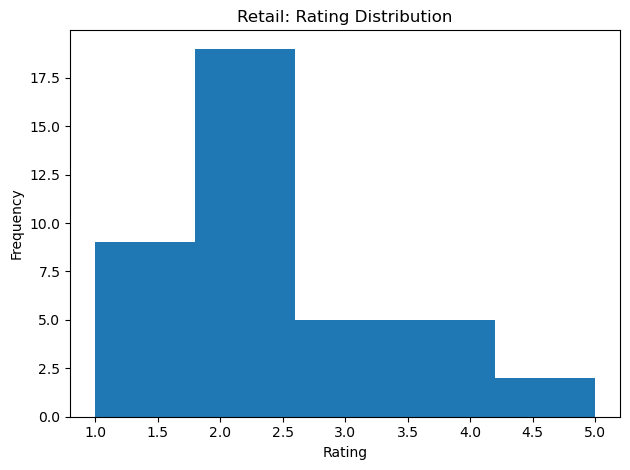

In [15]:
import matplotlib.pyplot as plt

# Rating distribution
plt.figure()
retail_clean['rating'].plot(kind='hist', bins=5)
plt.title('Retail: Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

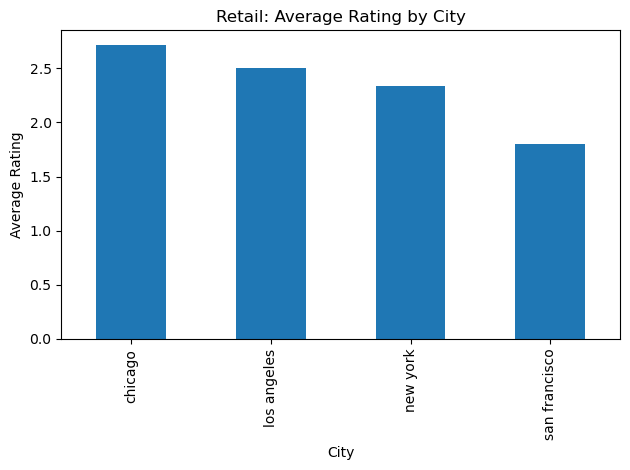

In [16]:
# Average rating by city (bar chart)
plt.figure()
retail_clean.groupby('store_city')['rating'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Retail: Average Rating by City')
plt.xlabel('City')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

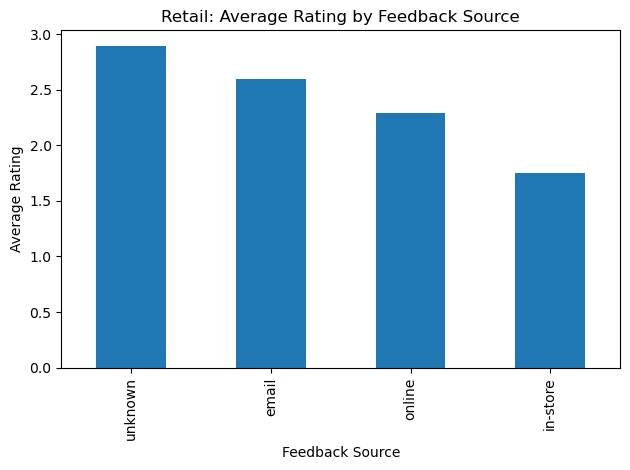

In [17]:
# Average rating by feedback source (bar chart)
plt.figure()
retail_clean.groupby('feedback_source')['rating'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Retail: Average Rating by Feedback Source')
plt.xlabel('Feedback Source')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

## 7. Basic Analysis & Visualisations (Students)

In [18]:
students_clean = pd.read_csv('student_performance_cleaned.csv', parse_dates=['exam_date'])
students_clean[['score', 'attempt']].describe()

,score,attempt
count,35.000000,35.000000
mean,70.628571,1.457143
std,12.716561,0.505433
min,45.000000,1.000000
25%,65.000000,1.000000
50%,72.000000,1.000000
75%,72.000000,2.000000
max,95.000000,2.000000


In [19]:
# Average score by subject
students_clean.groupby('subject')['score'].mean().sort_values(ascending=False)

subject
science    72.555556
history    72.222222
math       68.764706
Name: score, dtype: float64

In [20]:
# Average score by gender
students_clean.groupby('gender')['score'].mean().sort_values(ascending=False)

gender
unknown    74.727273
male       74.181818
female     64.153846
Name: score, dtype: float64

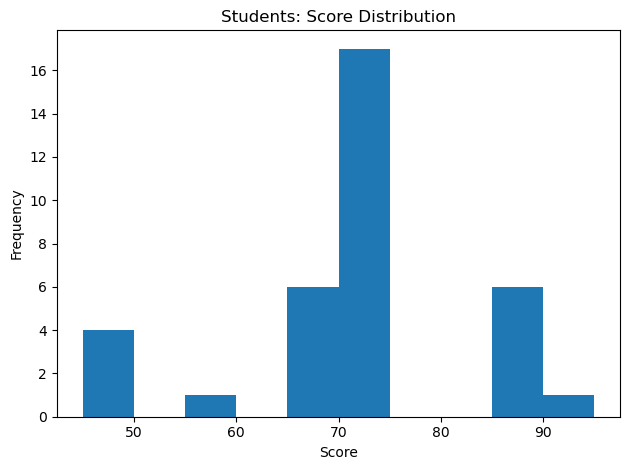

In [21]:
# Score distribution
plt.figure()
students_clean['score'].plot(kind='hist', bins=10)
plt.title('Students: Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

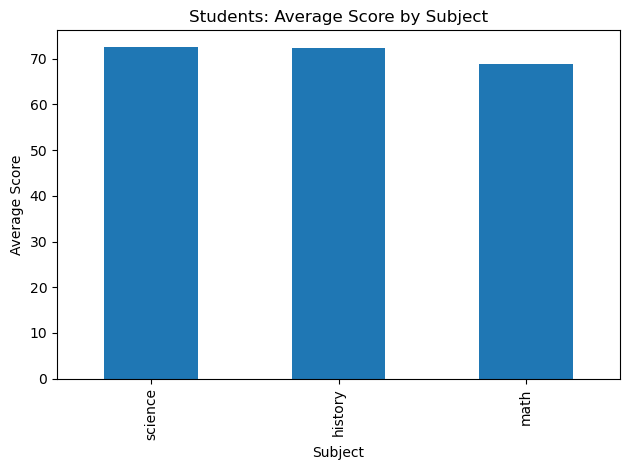

In [22]:
# Average score by subject (bar chart)
plt.figure()
students_clean.groupby('subject')['score'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Students: Average Score by Subject')
plt.xlabel('Subject')
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()

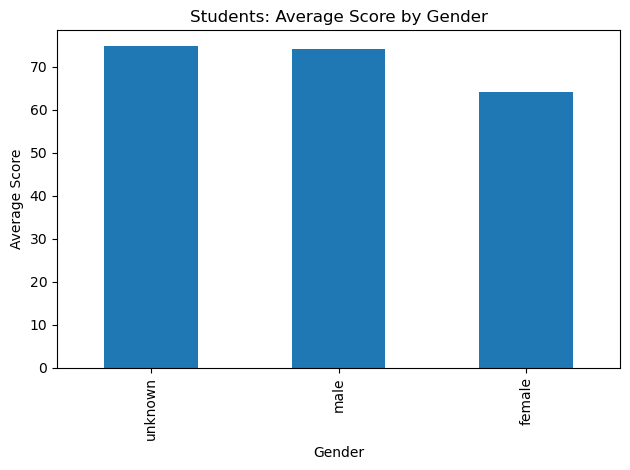

In [23]:
# Average score by gender (bar chart)
plt.figure()
students_clean.groupby('gender')['score'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Students: Average Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()